In [1]:
# importing required libraries :
import pandas as pd
import numpy as np
from numpy.matlib import repmat 
import matplotlib.pyplot as plt
from matplotlib import style
import sys
from scipy.io import loadmat
plt.style.use('ggplot')

### First we need to generate the binary data with :
- n/2 values in class 1 (Normal distribution ~ mean=0, sigma=1)
- n/2 values in class 2 (Normal distribution ~ mean= OFFSET, sigma=1)


#### We first need to define a function ***to_y_data*** to do the same :

In [2]:
## to construct the dataset

def toydata(offset,n):
  """ 

  the ceil function rounds up to the nearest integer
  -- so we will have ceil(n/2) points of class 2 and rest of class 1
  -- to generate gaussian dist :
   https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html
  
  -- to select randomly from the generated data :
  https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html

  """
  n_half = int(np.ceil(n/2))

  x = np.random.randn(n, 2)  # x N*2
  x[n_half :] = x[n_half :] * 2
  x[n_half:, :] += offset

  y = np.ones(n)
  y[n_half :] = y[n_half :] * 2

  m = np.random.permutation(n)

  return x[m,:] , y[m]

### 1. Noise in the dataset (unwanted values):

In [3]:
from numpy.core.memmap import ndarray
### we will use 'scipy.stats.norm' to generate normpdf :
import scipy.stats as stats

## creating the compute_y_bar function
def compute_y_bar(n_2_array, offset) :
  
  ## we need to create two variables to store the dimensionality(size) of the given array
  shape_1, shape_2 = n_2_array.shape

  ## creating an array to store the values :
  y_bar = np.zeros(shape_1)

  ## distributing the values to generate y_bar and storing the probabilities:

  for i in range(shape_1):
    p_1 = ndarray.prod(stats.norm.pdf(n_2_array[i], 0, 1)) * (1/2)
    p_2 = ndarray.prod(stats.norm.pdf(n_2_array[i], offset, 1)) * (1/2)

    ## calculating the probablities:

    prob_1 = p_1/ (p_1 + p_2)
    prob_2 = p_2/ (p_1 + p_2)

    y_bar[i] = prob_1 + prob_2 * 2


  return y_bar

### Implementing ridge regression

In [4]:
# calculating euclidean distance :

def l2distance(x, y=None) :

  if y is None:
        n, d = x.shape
        sum_1 = np.sum(np.power(x, 2), axis=1).reshape(-1,1)
        Dist_1 = -2 * np.dot(x, x.T) + repmat(sum_1, 1, n)
        Dist = Dist_1 + repmat(sum_1.T, n, 1)
        np.fill_diagonal(Dist, 0)
        Dist = np.sqrt(np.maximum(Dist, 0))
  else:
        n, d = x.shape
        m, _ = y.shape
        sum_1 = np.sum(np.power(x, 2), axis=1).reshape(-1,1)
        sum_2 = np.sum(np.power(y, 2), axis=1).reshape(1,-1)
        Dist_1 = -2 * np.dot(x, y.T) + repmat(sum_1, 1, m)
        Dist = Dist_1 + repmat(sum_2, n, 1)
        Dist = np.sqrt(np.maximum(Dist, 0))

  return Dist

### Error Visualisation (Plotting misclassified points) :

Final error using  Bayes classifier: 13.1%.


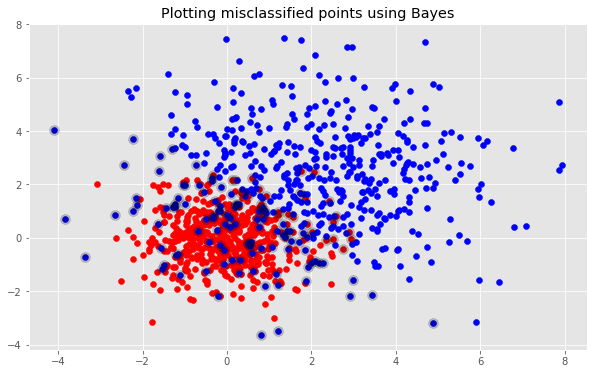

In [5]:
offset = 2
# given
x_2_array, y_2_array = toydata(offset, 1000)

# computing error

y_bar = compute_y_bar(x_2_array, offset)
predict = np.round(y_bar)
errors = predict != y_2_array
final_error = errors.sum() / len(y_2_array) * 100
print('Final error using  Bayes classifier: %.1f%%.' % final_error)

# plot data
i1 = y_2_array == 1
i2 = y_2_array == 2
plt.figure(figsize=(10,6))
plt.scatter(x_2_array[i1, 0], x_2_array[i1, 1], c='r', marker='o')
plt.scatter(x_2_array[i2, 0], x_2_array[i2, 1], c='b', marker='o')
plt.scatter(x_2_array[errors, 0], x_2_array[errors, 1], c='k', s=100, alpha=0.2)
plt.title("Plotting misclassified points using Bayes")
plt.show()

### Using ridge regression :

In [6]:
def kregression(xTr,yTr,sigma=0.1,lmbda=0.01):

    kernel = lambda x, z: np.power(1+(np.power(l2distance(x,z),2) / (2 * np.power(sigma,2))),-4)
    ridge = lambda K, lmbda2: K + lmbda * np.eye(K.shape[0], K.shape[1])
    beta = np.linalg.solve(ridge(kernel(xTr, xTr), lmbda), yTr)
    
    fun = lambda Xt: np.dot(kernel(Xt, xTr), beta)
    return fun

### Bias :

In [7]:
def computehbar(xTe, sigma, lmbda, Nsmall, NMODELS, OFFSET):

    n = xTe.shape[0]
    hbar = np.zeros(n)
    for j in range(NMODELS):

        xTr, yTr = toydata(OFFSET, Nsmall)
        fun = kregression(xTr, yTr, sigma, lmbda)
        hbar += fun(xTe)
        
    hbar /= NMODELS
    return hbar

### Variance :

In [8]:
def computevariance(xTe, sigma, lmbda, hbar, Nsmall, NMODELS, OFFSET):

    n = xTe.shape[0]
    variance = np.zeros(n)
    
    
    for j in range(NMODELS):

        xTr, yTr = toydata(OFFSET, Nsmall)
        fun = kregression(xTr, yTr, sigma, lmbda)
        pred = fun(xTe)
        diffSqr = (pred - hbar)**2
        variance += diffSqr
    
    variance = np.mean(variance)/NMODELS
    return variance

### Bias Variance demo :

In [9]:
# biasvariancedemo

# how big is the training set size N
Nsmall = 10
# how big is a really big data set (approx. infinity)
Nbig = 10000
# how many models do you want to average over
NMODELS = 100
# What regularization constants to evaluate
lmbdas = np.arange(-6, 0+0.5, 0.5)
# what is the kernel width?
sigma = 4

# we store
Nlambdas = len(lmbdas)
lbias = np.zeros(Nlambdas)
lvariance = np.zeros(Nlambdas)
ltotal = np.zeros(Nlambdas)
lnoise = np.zeros(Nlambdas)
lsum = np.zeros(Nlambdas)

# Different regularization constant classifiers
for md in range(Nlambdas):
    lmbda = 2 ** lmbdas[md]
    # use this data set as an approximation of the true test set
    xTe,yTe = toydata(offset,Nbig)
    
    # Estimate AVERAGE ERROR (TOTAL)
    total = 0
    for j in range(NMODELS):
        xTr2,yTr2 = toydata(offset,Nsmall)
        fsmall = kregression(xTr2,yTr2,sigma,lmbda)
        total += np.mean((fsmall(xTe) - yTe) ** 2)
    total /= NMODELS
    
    # Estimate Noise
    ybar = compute_y_bar(xTe, offset)
    noise = np.mean((yTe-ybar) ** 2)
    
    # Estimate Bias
    hbar = computehbar(xTe,sigma, lmbda, Nsmall, NMODELS, offset)
    bias = np.mean((hbar-ybar) ** 2)
    
    # Estimating VARIANCE
    variance = computevariance(xTe,sigma,lmbda,hbar, Nsmall, NMODELS, offset)
    
    # print and store results
    lbias[md] = bias
    lvariance[md] = variance
    ltotal[md] = total
    lnoise[md] = noise
    lsum[md] = lbias[md]+lvariance[md]+lnoise[md]
    print('Regularization = %2.1f,  Bias = %2.4f, Variance = %2.4f, Noise = %2.4f, Sum of Bias,Variance and Noise = %2.4f, Testing error = %2.4f'
          % (lmbdas[md],lbias[md],lvariance[md],lnoise[md],lsum[md],ltotal[md]))

Regularization = -6.0,  Bias = 0.1272, Variance = 0.1786, Noise = 0.1292, Sum of Bias,Variance and Noise = 0.4351, Testing error = 0.4005
Regularization = -5.5,  Bias = 0.1060, Variance = 0.1600, Noise = 0.1284, Sum of Bias,Variance and Noise = 0.3944, Testing error = 0.4244
Regularization = -5.0,  Bias = 0.1117, Variance = 0.1332, Noise = 0.1234, Sum of Bias,Variance and Noise = 0.3683, Testing error = 0.4022
Regularization = -4.5,  Bias = 0.1072, Variance = 0.1146, Noise = 0.1274, Sum of Bias,Variance and Noise = 0.3493, Testing error = 0.3789
Regularization = -4.0,  Bias = 0.1351, Variance = 0.1136, Noise = 0.1293, Sum of Bias,Variance and Noise = 0.3780, Testing error = 0.3801
Regularization = -3.5,  Bias = 0.1281, Variance = 0.1078, Noise = 0.1313, Sum of Bias,Variance and Noise = 0.3672, Testing error = 0.3544
Regularization = -3.0,  Bias = 0.1401, Variance = 0.0893, Noise = 0.1293, Sum of Bias,Variance and Noise = 0.3587, Testing error = 0.3980
Regularization = -2.5,  Bias = 0.1

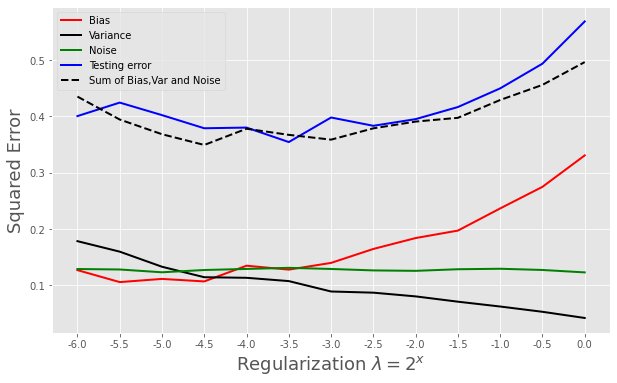

In [10]:
# plotting the  results

plt.figure(figsize=(10,6))
plt.plot(lbias[:Nlambdas],c='r',linestyle='-',linewidth=2)
plt.plot(lvariance[:Nlambdas],c='k', linestyle='-',linewidth=2)
plt.plot(lnoise[:Nlambdas],c='g', linestyle='-',linewidth=2)
plt.plot(ltotal[:Nlambdas],c='b', linestyle='-',linewidth=2)
plt.plot(lsum[:Nlambdas],c='k', linestyle='--',linewidth=2)

plt.legend(["Bias","Variance","Noise","Testing error","Sum of Bias,Var and Noise"]);
plt.xlabel("Regularization $\lambda=2^x$",fontsize=18);
plt.ylabel("Squared Error",fontsize=18);
plt.xticks([i for i in range(Nlambdas)],lmbdas);